In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses TensorFlow INFO, WARNING, ERROR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mediapipe as mp
import cv2
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

In [4]:
data = []
labels = []

DATA_DIR = "asl_dataset"

for label in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, label)
    for img_file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        img_path = os.path.join(folder_path, img_file)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            landmark_list = []
            for lm in results.multi_hand_landmarks[0].landmark:
                landmark_list.extend([lm.x, lm.y, lm.z])
            data.append(landmark_list)
            labels.append(label)

Processing Z: 100%|██████████████████████████████████████████████████████████████████| 301/301 [00:22<00:00, 13.56it/s]


In [5]:
X = np.array(data)
y = np.array(labels)

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
X.shape

(7826, 63)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        61
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00        60
           9       1.00      1.00      1.00        60
          10       1.00      1.00      1.00        61
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        60
          13       1.00      1.00      1.00        60
          14       1.00      1.00      1.00        61
          15       1.00      1.00      1.00        60
          16       1.00      1.00      1.00        60
          17 

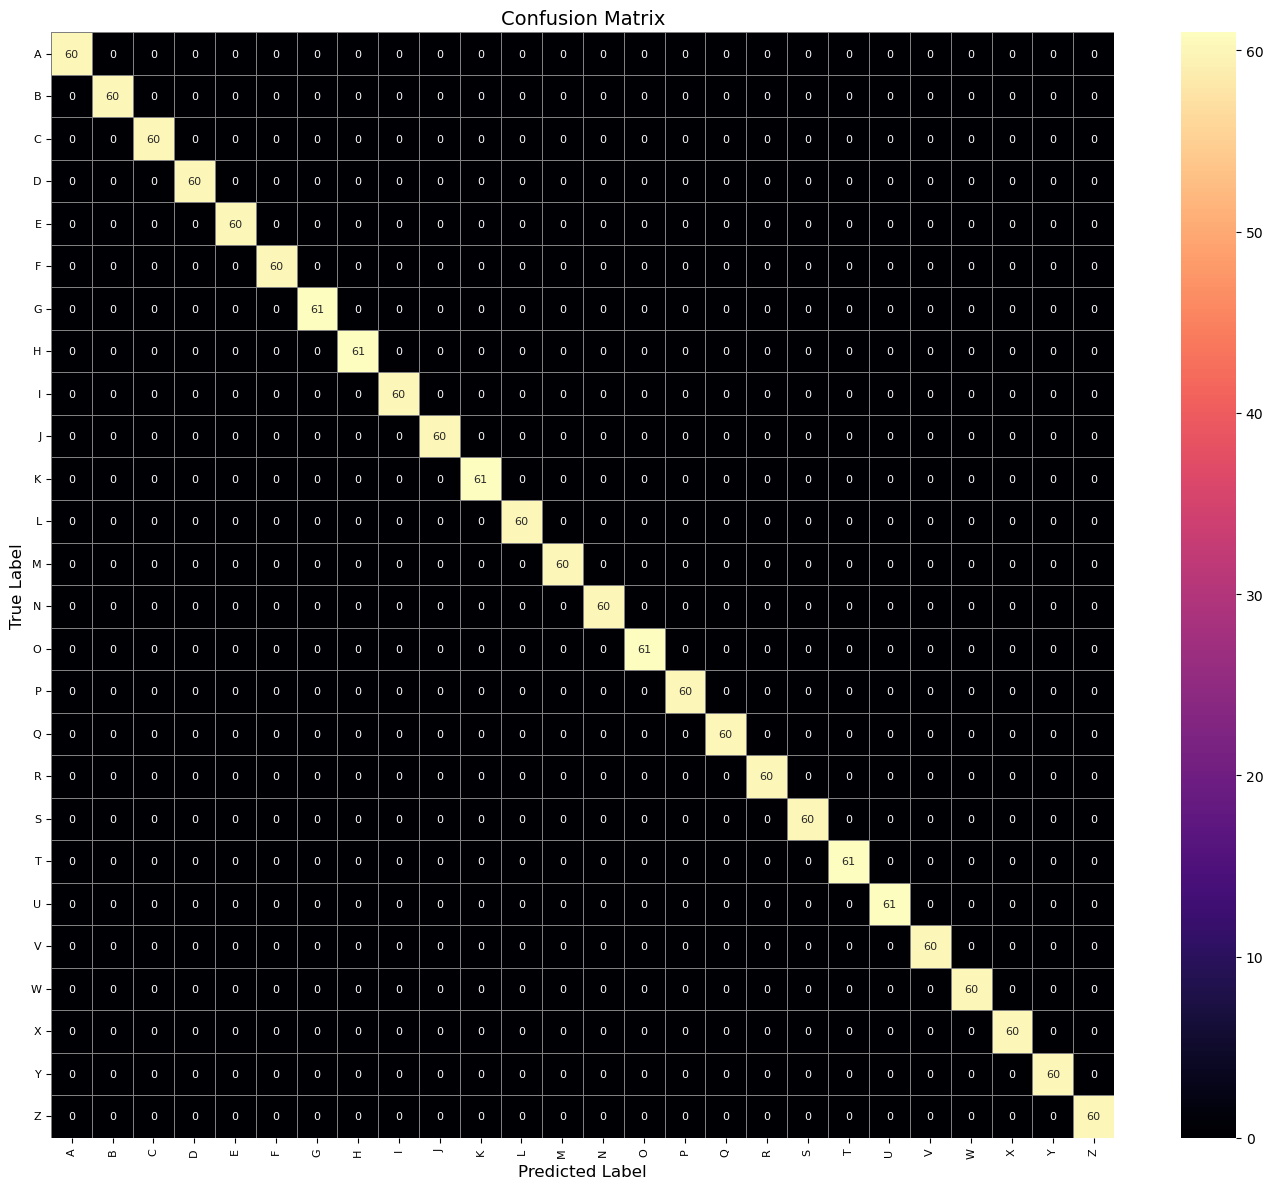

In [11]:
cm = confusion_matrix(y_test, y_pred)

# Get label names from label encoder
labels = le.classes_

plt.figure(figsize=(14, 12))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='magma', 
            linewidths=0.5, 
            linecolor='gray',
            xticklabels=labels,
            yticklabels=labels,
            annot_kws={"size": 8})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

In [12]:
import joblib
joblib.dump(model, 'rf_model.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [14]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp
import joblib  # If you want to save/load the model
import time

# Load MediaPipe hand detector
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# Assume model and label encoder already trained
# model = ... (already trained)
# le = ... (already fitted)
# If you saved them, load like this:
# model = joblib.load("rf_model.pkl")
# le = joblib.load("label_encoder.pkl")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Mirror image
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract features
            landmark_list = []
            for lm in hand_landmarks.landmark:
                landmark_list.extend([lm.x, lm.y, lm.z])

            if len(landmark_list) == 63:
                prediction = model.predict([landmark_list])[0]
                predicted_label = le.inverse_transform([prediction])[0]

                # Draw prediction on frame
                cv2.putText(frame, f'Predicted: {predicted_label}', (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Sign Language Recognizer", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
